# Understanding Factors Contributing to Customer Churn at Telco

Author: Blake Nhul
Date Completed: 11/23/2021

This is my first data analysis completed for my github repository :).  I am hoping to do a lot more of these for fun!

## Problem

We are tasked with understanding the factors that are contributing to customer churn at Telco and what we can do to mitigate customer churn.  Telco is a fictional telecommunications company that was created by IBM.

## Data Collection

<b><u> Some of the Basic Information </u></b><br>
Two datasets were pulled from the IBM community datasets.  There is a main dataset and a dataset with some survey information on understanding the reason the customer decided to leave.  This data was pulled on 11/15/2021.  The files used in the analysis will also be on the github repository.

<b>Github repository: </b> https://github.com/blakingtheice/Telco-Customer-Churn

<b> Links to Datasets </b>

Main dataset: https://community.ibm.com/accelerators/catalog/content/Customer-churn
<br>Survey Data: https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn-status-and-reason-for-leaving


<b> Reading in the data </b>

In [21]:
# Importing modules

import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import time

## Importing the data in

file_path = os.getcwd()
main_data = pd.read_excel(file_path + "\\Data\\CustomerChurn.xlsx")
survey_data = pd.read_excel(file_path + "\\Data\\Telco_customer_churn_status.xlsx")

In [22]:
print("Pandas Version: ",pd.__version__)
print("Numpy Version: ",np.__version__)
print("Seaborn Version: ",sns.__version__)
print("Sci-kit learn Version: ",sklearn.__version__)
print("Matplotlib Version: ", matplotlib.__version__)

Pandas Version:  1.3.2
Numpy Version:  1.21.2
Seaborn Version:  0.11.2
Sci-kit learn Version:  1.0
Matplotlib Version:  3.4.3


<b><u> Dataset Descriptions </u></b><br><br>
<b> Main Dataset </b>

The main dataset includes a variety of information on the services that the customer uses, whether they have churned or not, and information like whether the customer has dependents.

We can take a look at how the data is stored in general and the general types by eyeballing the output below:

In [23]:
main_data.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<b> Survey Dataset </b>

The survey dataset has information about why a customer churned, their satisfaction scores, and customer life time value (CLTV).

We can take a quick look at what the dataset looks like below:

In [24]:
survey_data.head()

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


<b> Merging the Data Together </b>

In [25]:
main_merge = main_data.merge(survey_data,how='left',on='Customer ID')
main_merge.loc[main_merge['Total Charges'] == " ",'Total Charges'] = 0
main_merge['Total Charges'] = pd.to_numeric(main_merge['Total Charges'])

## Exploring the Data

### Analyzing the Survey Results:  What can we find?

We want to understand more about why customer churn has been happening.  The survey data has some useful information on this that we may want to take a look at.

Approximately 27% (1869 out of 7043) of the customers have churned, but there might be some interesting pieces of information that the business can use from the survey results.  If the survey results can provide us some actionable insights as to why customers might be leaving, we can potentially do some research within areas of the business that are responsible for those and see if there are any initiatives we can do to possibly reduce the churn rate.

In [26]:
## Showing # of customers that have churned and that haven't churned

churn_count = main_merge[['Churn','Count']].groupby(by="Churn",as_index=False).sum()
print(churn_count)
no_churn = churn_count[['Count']].loc[churn_count['Churn'] == "No"].sum()[0]
print("=======")
print("Total Customers: ", main_merge.shape[0])
print("% No Churn: ",round(no_churn / main_merge.shape[0],2))
print("% Churn: ", 1 - round(no_churn / main_merge.shape[0],2))

  Churn  Count
0    No   5174
1   Yes   1869
Total Customers:  7043
% No Churn:  0.73
% Churn:  0.27


In [27]:
churn_reason = main_merge[['Churn Category',
                           'Churn Reason',
                           'Count','Satisfaction Score',
                          'CLTV']].groupby(by=['Churn Category','Churn Reason'],
                                             as_index=False).agg({'Count':'sum',
                                                                 'Satisfaction Score':'mean',
                                                                 'CLTV':'mean'})
                                                                 
churn_category = main_merge[['Churn Category',
                           'Count','Satisfaction Score',
                          'CLTV']].groupby(by='Churn Category',
                                             as_index=False).agg({'Count':'sum',
                                                                 'Satisfaction Score':'mean',
                                                                 'CLTV':'mean'}).sort_values(by="Count",
                                                                              ascending=False)

print("Total Customers Churned: ", churn_category['Count'].sum())

Total Customers Churned:  1869


In [28]:
churn_category

,Churn Category,Count,Satisfaction Score,CLTV
1,Competitor,841,1.546968,4177.512485
0,Attitude,314,2.041401,4161.375796
2,Dissatisfaction,303,1.709571,4153.778878
4,Price,211,1.819905,4165.142180
3,Other,200,2.005000,3989.280000


Seems like a majority of the customers churned due to the competitor (841 out of 1869, or 45%), but there is a good chunk of customers that are dissatisfied (303 out of 1869) and perhaps didn't quite like the customer service that they were receiving (314 out of 1869).  we can take a deeper dive into each of these categories to find out the specific reason that was highlighted.  The satisfaction scores seem to be lower  in the dissatisfaction and competitor categories...  Satisfaction might be lower overall in general for customers that churn.

And we see that in general they seem to be much lower in the group that churns versus the group that doesn't churn.

In [29]:
main_merge[['Churn','Satisfaction Score']].groupby(by='Churn',as_index=False).mean()

,Churn,Satisfaction Score
0,No,3.789911
1,Yes,1.736223


We know that nearly 45% of the customers are churning due to the competitor and that attitude and dissatisfaction are also seem to be a problem as well (accounting for 78% of the reported reason for customer churn), but we might want to be more specific..

Let's look further into that and look at the top problems overall...

#### Competitor Churn Category

We take a look into the competitor churn category and notice that those that churned within the competitor churn category churned mostly because the competitor made better offers (better pricing perhaps?) and had better devices.  This made up about 74% (624 out of 841) of the competitor churn category.  In general it might be helpful to conduct some further analysis on what the competitors are offering with concerns to their product and other offerings.  It seems like the competitor may have something better to offer that Telco may not have and that could put Telco at a further disadvantage in the future.

In [30]:
churn_reason['Total CLTV'] = churn_reason['Count'] * churn_reason['CLTV']
churn_reason = churn_reason.sort_values(by="Count",ascending=False)
churn_reason.loc[churn_reason['Churn Category'] == 'Competitor']

,Churn Category,Churn Reason,Count,Satisfaction Score,CLTV,Total CLTV
2,Competitor,Competitor had better devices,313,1.035144,4146.568690,1297876.0
3,Competitor,Competitor made better offer,311,1.858521,4244.247588,1319961.0
5,Competitor,Competitor offered more data,117,1.914530,4217.042735,493394.0
4,Competitor,Competitor offered higher download speeds,100,1.750000,4020.570000,402057.0


#### Attitude Churn Category

There aren't too many reasons for the attitude, it does seem like the attitude of the support person seemed to be the biggest reason within the attitude churn category.  Perhaps there might be some insight looking into customer service interactions and seeing if there are ways to better serve the customer with better customer service training.


In [31]:
churn_reason.loc[churn_reason['Churn Category'] == 'Attitude']

,Churn Category,Churn Reason,Count,Satisfaction Score,CLTV,Total CLTV
1,Attitude,Attitude of support person,220,2.013636,4145.513636,912013.0
0,Attitude,Attitude of service provider,94,2.106383,4198.500000,394659.0


#### Dissatisfaction Churn Category

Product dissatisfcation, network reliability, and service dissatisfaction seem to be the top 3 categories within the dissatisfaction churn category.  It might be helpful to conduct further research about what specific aspects of the product that the customer might have not liked.

As for network reliability, it might make sense to think about improvement opportunities that the business can make in network reliability.  Are there some low hanging fruits that can improve it?

In [32]:
churn_reason.loc[churn_reason['Churn Category'] == 'Dissatisfaction']

,Churn Category,Churn Reason,Count,Satisfaction Score,CLTV,Total CLTV
11,Dissatisfaction,Product dissatisfaction,77,1.090909,4232.584416,325909.0
8,Dissatisfaction,Network reliability,72,1.958333,4045.055556,291244.0
12,Dissatisfaction,Service dissatisfaction,63,1.777778,4196.587302,264385.0
7,Dissatisfaction,Limited range of services,37,2.027027,4238.459459,156823.0
6,Dissatisfaction,Lack of self-service on Website,29,1.827586,4294.862069,124551.0
9,Dissatisfaction,Poor expertise of online support,13,2.153846,3827.000000,49751.0
10,Dissatisfaction,Poor expertise of phone support,12,2.083333,3827.666667,45932.0


#### Price Churn Category

It seems like a lot of the customers think the price is too high and that they don't like long distance charges as much.  Is there something that can be done here?  Can we look further into pricing or bring more value to the customer to justify a higher price?

In [33]:
churn_reason.loc[churn_reason['Churn Category'] == 'Price']

,Churn Category,Churn Reason,Count,Satisfaction Score,CLTV,Total CLTV
20,Price,Price too high,78,1.846154,4305.179487,335804.0
19,Price,Long distance charges,64,1.781250,4218.343750,269974.0
17,Price,Extra data charges,39,1.820513,3755.948718,146482.0
18,Price,Lack of affordable download/upload speed,30,1.833333,4219.500000,126585.0


#### Other Churn Category

Any insights to obtain from here?  Doesn't look like there's much to see here....

In [34]:
churn_reason.loc[churn_reason['Churn Category'] == 'Other']

,Churn Category,Churn Reason,Count,Satisfaction Score,CLTV,Total CLTV
14,Other,Don't know,130,1.815385,3991.107692,518844.0
15,Other,Moved,46,2.173913,3796.369565,174633.0
16,Other,Poor expertise of online support,18,2.944444,4366.888889,78604.0
13,Other,Deceased,6,2.000000,4295.833333,25775.0


### Churn vs Other Factors

Let's take a look into what kinds of factors contribute to churn!

In [35]:
main_merge.columns

Index(['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn', 'Count',
       'Quarter', 'Satisfaction Score', 'Customer Status', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason'],
      dtype='object')

#### Churn vs Satisfaction Score

Customers that have churned tend to have much lower satisfaction scores.  The interesting part is that customers who have churned do not have a satisfaction score above 3.  Satisfaction score might be important in predicting customer churn...

If this is the case, we could potentially use surveys to see where customer satisfaction sits with for customers and if their satisfaction is lower... we might want to flag these customers and find out why this might be the case to mitigate the risk...

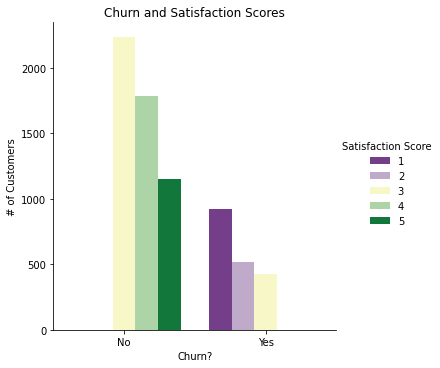

In [36]:
score_palette = sns.color_palette(['#7b3294','#c2a5cf','#ffffbf','#a6dba0','#008837'])
figure = sns.catplot(x='Churn Label',kind='count',hue='Satisfaction Score',palette=score_palette,data=main_merge)
figure.set(title="Churn and Satisfaction Scores",xlabel="Churn?",ylabel='# of Customers')

#### Churn and Demographics

There are some datapoints collected from customers that give a little more information about their demographics, such as whether the customer is a senior citizen, has a partner, and/or has dependents.

There seems to be some interesting initial patterns within our data:
- Senior citizens tend to churn at a higher rate
- Those with partners and dependents tend to churn at a lower rate

What about senior citizens with partners or dependents?

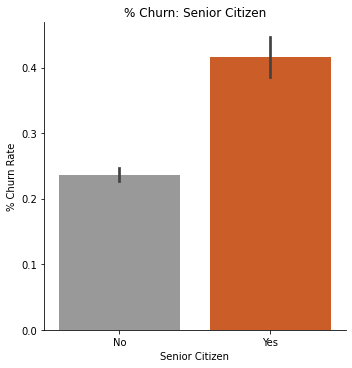

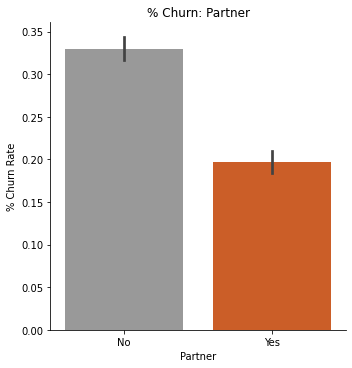

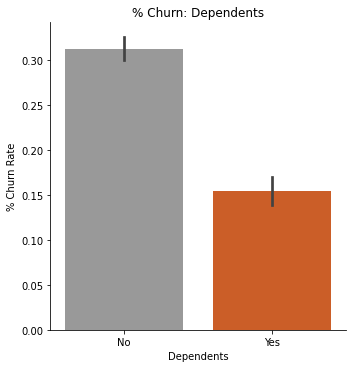

In [37]:
demo_columns = ['Senior Citizen', 'Partner', 'Dependents']

no_yes_palette = sns.color_palette(['#999999','#e6550d'])
for x in demo_columns:
    new_col = x + '?'
    main_merge[new_col] = np.where(main_merge[x] == 'Yes',1,0)


for var in demo_columns:
    title_text = "% Churn: " + var
    sns.catplot(x=var,
                y="Churn Value",
                kind='bar',
                data=main_merge,
                palette=no_yes_palette,
                order = ['No','Yes']).set(title=title_text,ylabel="% Churn Rate")

If we take a look at the graphs for looking at senior citizens who have partners and dependents, we can see something interesting.  Regardless if the person is a senior citizen, the churn rate was much lower if the customer had a partner or dependents.

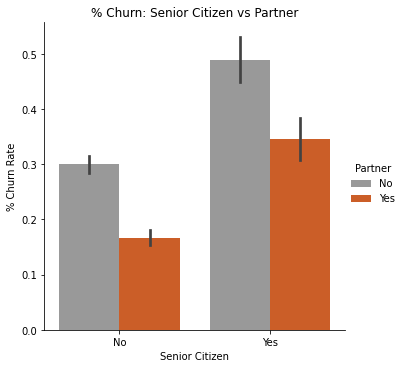

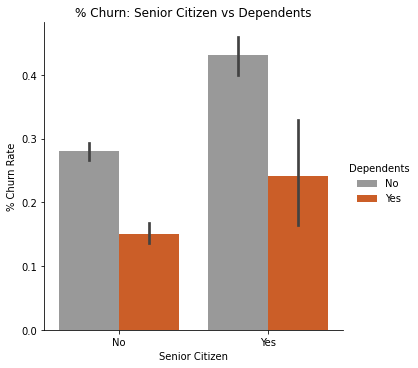

In [38]:
for var in ['Partner','Dependents']:
    title_text = "% Churn: Senior Citizen vs " + var
    sns.catplot(x='Senior Citizen',
                y="Churn Value",
                hue=var,
                kind='bar',
                data=main_merge,
                order = ['No','Yes'],
                hue_order=['No','Yes'],
               palette = no_yes_palette).set(title=title_text,ylabel="% Churn Rate")

We may want to ask ourselves, why do senior citizens tend to have a much higher churn rate?  I wonder what their satisfaction scores are...  Just for fun let's take a look!

There doesn't seem to be much of a difference in the satisfaction scores between senior citizens....  What do their survey results say?

In [39]:
main_merge[['Senior Citizen','Satisfaction Score']].groupby('Senior Citizen',as_index=False).median()

,Senior Citizen,Satisfaction Score
0,No,3.0
1,Yes,3.0


<b> Taking a look at their survey results </b>

It doesn't really seem like there is a specific churn reason that deviates from our prior analysis on the survey results in general.  

In [40]:
senior = main_merge.loc[main_merge['Senior Citizen'] == 'Yes']

sr_churn_reason = senior[['Churn Category',
                           'Churn Reason',
                           'Count','Satisfaction Score',
                          'CLTV']].groupby(by=['Churn Category','Churn Reason'],
                                             as_index=False).agg({'Count':'sum',
                                                                 'Satisfaction Score':'mean',
                                                                 'CLTV':'mean'})

sr_churn_category = senior[['Churn Category',
                           'Count','Satisfaction Score',
                          'CLTV']].groupby(by=['Churn Category'],
                                             as_index=False).agg({'Count':'sum',
                                                                 'Satisfaction Score':'mean',
                                                                 'CLTV':'mean'})
sr_churn_category['% Total Senior Citizen'] = sr_churn_category['Count']/sr_churn_category['Count'].sum()

In [41]:
sr_churn_category

,Churn Category,Count,Satisfaction Score,CLTV,% Total Senior Citizen
0,Attitude,89,1.977528,4256.269663,0.186975
1,Competitor,213,1.553991,4161.079812,0.447479
2,Dissatisfaction,75,1.560000,4165.480000,0.157563
3,Other,43,2.069767,4060.069767,0.090336
4,Price,56,1.946429,4282.000000,0.117647


#### Churn vs Charges and Payment Methods

Customers who prefer paperless billing and use electronic checks tend to have higher churn rates.  We only know these as associations, we might want to better understand why this might be the case...

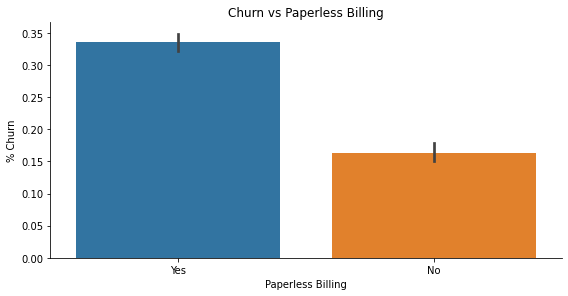

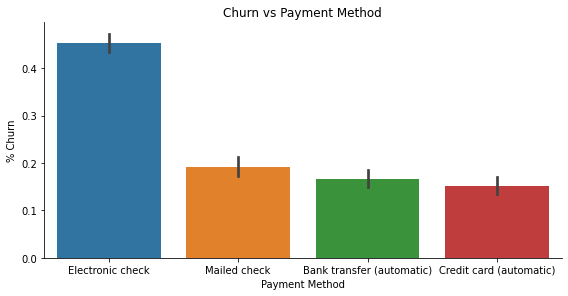

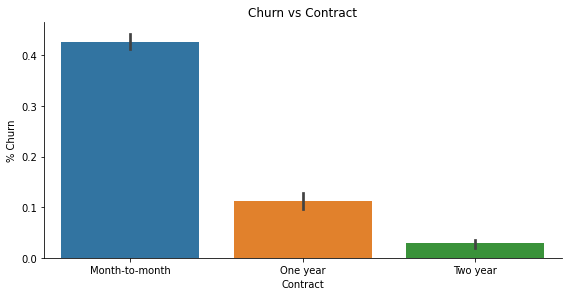

In [42]:
## Script goes here
import textwrap
main_merge.columns


categorical_cols = ['Paperless Billing','Payment Method','Contract']
charges_cols = ['Monthly Charges', 
                         'Total Charges','CLTV']


## Categorical analysis
for var in categorical_cols:
    title_text = "Churn vs " + var
    ax = sns.catplot(x=var,
               y="Churn Value",
                kind='bar',
               data=main_merge,height=4,aspect = 2)
    ax.set(title = title_text,ylabel='% Churn')

Double checking to see how often each of the payment methods are used.  It looks like the electronic check is used the most often.  What's interesting is that automatic payments is associated with lower churn rates and the mailed check methods.  Not too surprising that the month to month contracts have the largest churn rates vs the other contract types.

In [43]:
print(main_merge[['Payment Method','Churn Value','Count']].groupby(by='Payment Method',as_index=False).sum())
print("------------------------")
print(main_merge[['Paperless Billing','Churn Value','Count']].groupby(by='Paperless Billing',as_index=False).sum())

              Payment Method  Churn Value  Count
0  Bank transfer (automatic)          258   1544
1    Credit card (automatic)          232   1522
2           Electronic check         1071   2365
3               Mailed check          308   1612
------------------------
  Paperless Billing  Churn Value  Count
0                No          469   2872
1               Yes         1400   4171


<b> Taking a Look at Charges and CLTV </b>

It makes sense that the total charges might be smaller in the customer churn, more loyal customers that have stayed onger will have more total charges on average.  It does seem that the monthly charges are higher for the customers that have churned.  Perhaps this has something to do with the pricing complaints that we mentioned earlier after looking at the survey?

,Churn Label,Monthly Charges,Total Charges,CLTV
0,No,64.425,1679.525,4620.0
1,Yes,79.650,703.550,4238.0


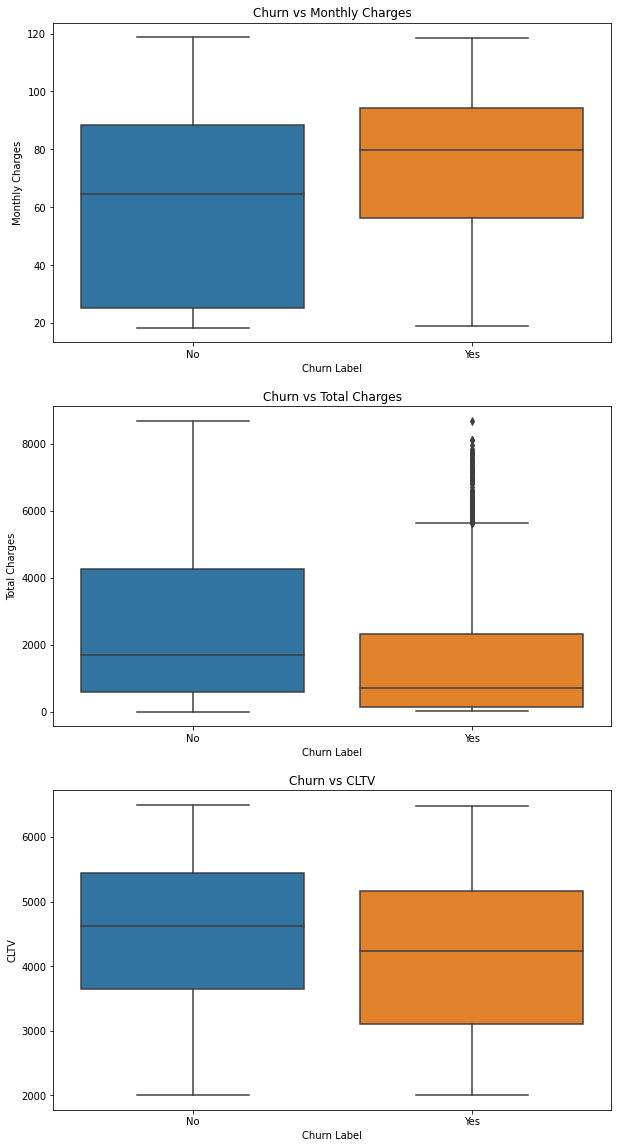

In [44]:
fig = plt.figure(figsize=(10,20))
gs = fig.add_gridspec(3,1)

i = 0
for var in charges_cols:
    ax = fig.add_subplot(gs[i,0])
    title_text = "Churn vs " + var
    sns.boxplot(x='Churn Label',
                  y=var,
                  data=main_merge)
    ax.set(title = title_text)
    i = i + 1
    
    
main_merge[['Churn Label','Monthly Charges','Total Charges','CLTV']].groupby(by ='Churn Label',as_index=False).median()

Perhaps it is worth taking a look at the survey results and how much those who complained about pricing paid monthly.

Hmmm after looking at the graph below it doesn't seem like there's really that much of a difference between the churn categories with regards to the monthly charges.

[Text(0.5, 1.0, 'Monthly Charges by Churn Category')]

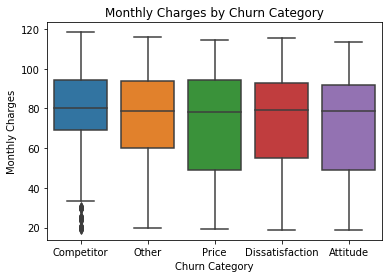

In [45]:
sns.boxplot(x='Churn Category',
           y='Monthly Charges',
           data=main_merge).set(title="Monthly Charges by Churn Category")

#### Churn vs Services

Now let's take a look at how churn relates to whether the customer has certain services or not.

Some interesting insights, customers that did not have the following had higher churn rates
- Tech support
- Online backup
- Online security

We only know this is associated with higher churn rates if they did not have it.  We might have to dig deeper into this by accounting for other variables with a multivariate analysis.  Which we will take a look at next.

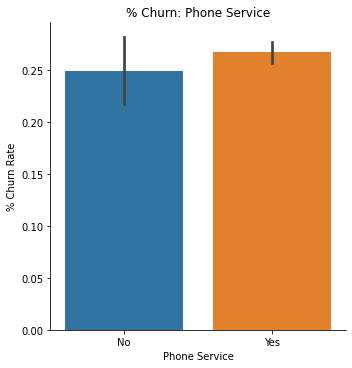

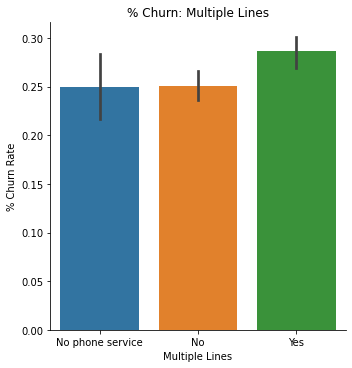

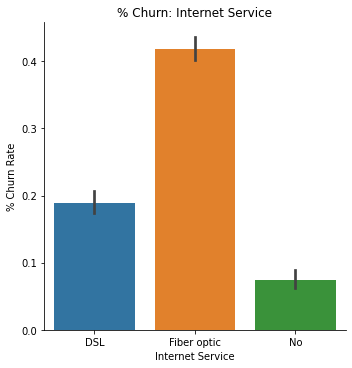

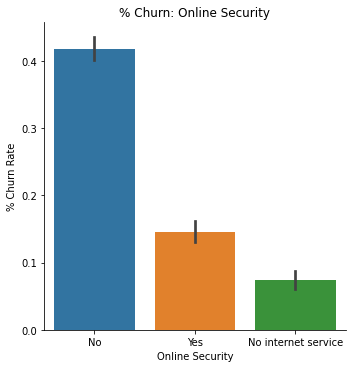

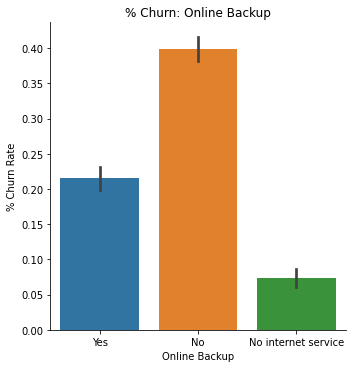

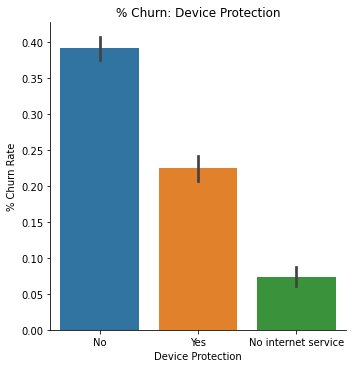

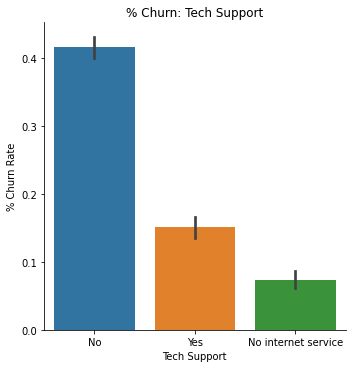

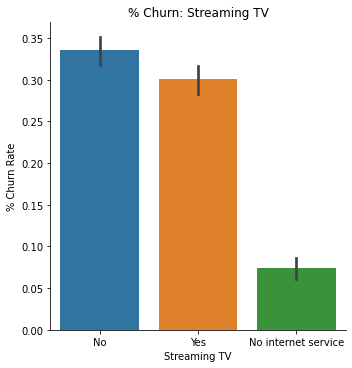

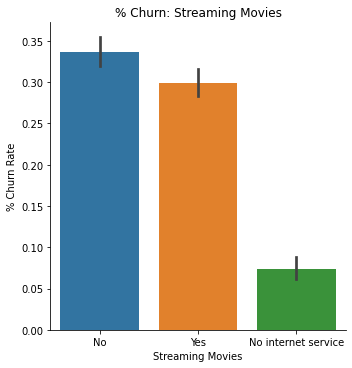

In [46]:
main_merge.columns

services_cols = ['Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies']

for var in services_cols:
    title_text = "% Churn: " + var
    sns.catplot(x=var,
                y="Churn Value",
                kind='bar',
                data=main_merge).set(title=title_text,ylabel="% Churn Rate")

## Identifying the Most Important Factors in Identifying Customer Churn
### Determining models to use for the analysis

We want to suggest recommendations to the business on what could be contributing to the customer churn as well, so we may need a model that is easier to interpret initially.  Once we understand what kinds of factors (if there are any factors that do) that do contribute to customer churn, we can mitigate the customer churn risk before it happens.

### Preprocessing the data

We will need to process some of the categorical variables in the dataset, since there is quite a few in the dataset.  I am going to encode them using the OneHotEncoder function in skl earn.  I also need to prepare the data by dropping the less important columns of interest when running the model.

In [47]:

oe_encoder = OneHotEncoder()
req_encoding = ['Senior Citizen','Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method']
# go through each of the columns requiring encoding, merge them into the main dataset
for x in req_encoding:
    oe_results = oe_encoder.fit_transform(main_merge[[x]])
    test_col = oe_encoder.categories_[0]
    columns_append =  [x + "_" + y for y in test_col]
    append_df = pd.DataFrame(oe_results.toarray(),columns=columns_append)
    main_merge = pd.concat([main_merge,append_df],axis=1)
    
# Remove original columns
telco_data = main_merge.drop(['Senior Citizen','Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method','Count','Churn','Churn Reason','Churn Category',
                              'Quarter','Customer Status','Churn Score','Senior Citizen?',
                             'Dependents?','Partner?','Churn Label'],axis=1)

### Logistic Regression Modeling - L1 and L2 Penalization

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import time

x_cols = [ 'Tenure', 'Monthly Charges',
       'Total Charges', 'Satisfaction Score', 'CLTV',
       'Senior Citizen_No', 'Senior Citizen_Yes', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'Phone Service_No',
       'Phone Service_Yes', 'Multiple Lines_No',
       'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_DSL', 'Internet Service_Fiber optic',
       'Internet Service_No', 'Online Security_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Online Backup_No', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Device Protection_No',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Streaming TV_No',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No', 'Streaming Movies_No internet service',
       'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Paperless Billing_No', 'Paperless Billing_Yes',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check']

churn = telco_data['Churn Value']
x = telco_data[x_cols]

x_train,x_test,y_train,y_test = train_test_split(
    x,churn,test_size=0.2,random_state=1)

## LR Model - L1

start = time.time()
lr_fit = LogisticRegression(random_state=0,solver='liblinear',penalty='l1').fit(x_train,y_train)

predictor_names = np.array(x.columns).reshape(x.columns.shape[0],1)
coef_l1 = np.round(lr_fit.coef_,2)[0].reshape(lr_fit.coef_.shape[1],1)

predicted_vals = lr_fit.predict(x_test)
end = time.time()
time_record = end - start

LR_L1_metrics = [round(accuracy_score(y_test,predicted_vals),2),
                 round(precision_score(y_test,predicted_vals),2),
                 round(recall_score(y_test,predicted_vals),2),
                 round(time_record,2)]

## LR Model - L2
start = time.time()
lr_fit2 = LogisticRegression(random_state=0,solver='liblinear',penalty='l2').fit(x_train,y_train)
coef_l2 = np.round(lr_fit2.coef_,2)[0].reshape(lr_fit2.coef_.shape[1],1)

predicted_vals = lr_fit2.predict(x_test)
end = time.time()
time_record = end - start

LR_L2_metrics = [round(accuracy_score(y_test,predicted_vals),2),
                 round(precision_score(y_test,predicted_vals),2),
                 round(recall_score(y_test,predicted_vals),2),
                 round(time_record,2)]

## Forming Summary Matrices

coef_matrix = np.concatenate((predictor_names,coef_l1,coef_l2),axis=1)
coef_matrix_lr = pd.DataFrame(coef_matrix,columns=['Variable','LR-L1: Coef','LR-L2: Coef'])
metric_name = ['Accuracy','Precision','Recall','Time to Run (Seconds)']
metrics = {'Metric': metric_name,
           'LR - L1' : LR_L1_metrics,
           'LR - L2' : LR_L2_metrics}

perf_metrics = pd.DataFrame(metrics)

## Adding predicted churn class and probabilities back into the dataset
predicted_churn_prob = lr_fit.predict_proba(x)[:,1]
predicted_churn = lr_fit.predict(x)
main_merge['Predicted Churn Prob'] = predicted_churn_prob
main_merge['Predicted Churn Class'] = predicted_churn

### Interpreting and Evaluating Model Performance

We used a logistic regression model since it is easily interpretable (this will be great for offering suggestions to lower churn risk), runs relatively quickly, and provides some decent predictive power in identifying churn risk.

#### Interpretation of Results

Below is a table of coefficients for our model.
Positive coefficients mean that when accounting for other variables, increases in this variable is associated with an increase in the likelihood for customer churn.  Negative coefficients are the opposite, increases in the variable is associated with a decrease in the likelihood for customer churn.

We identified earlier that satisfaction scores seem to be pretty predictive of whether or not people will churn.  It might also be pretty difficult to obtain data wise (but powerful) unless we implement a system that periodically checks in for customer satisfaction.

In [49]:
coef_matrix_lr

,Variable,LR-L1: Coef,LR-L2: Coef
0,Tenure,-0.05,-0.03
1,Monthly Charges,0.03,0.06
2,Total Charges,0.0,0.0
3,Satisfaction Score,-5.45,-3.86
4,CLTV,-0.0,0.0
5,Senior Citizen_No,1.79,0.43
6,Senior Citizen_Yes,2.02,0.54
7,Partner_No,1.57,0.49
8,Partner_Yes,1.54,0.48
9,Dependents_No,1.69,0.68


#### Evaluating the predictive power of our model

We compare the logistic regression model with L1 and L2 penalization of the parameters.  The time it takes to run both models is pretty negligible it looks like as well.  The predictive performance for both of the models is also fairly similar as well.



In [50]:
perf_metrics

,Metric,LR - L1,LR - L2
0,Accuracy,0.95,0.95
1,Precision,0.93,0.95
2,Recall,0.85,0.84
3,Time to Run (Seconds),0.07,0.03


In [51]:
conditions = [(main_merge['Churn Value'] == 1) & (main_merge['Predicted Churn Class'] == 1),
              (main_merge['Churn Value'] == 0) & (main_merge['Predicted Churn Class'] == 0),
             (main_merge['Churn Value'] - main_merge['Predicted Churn Class']) > 0,
             (main_merge['Churn Value'] - main_merge['Predicted Churn Class']) < 0]

values = ['Correctly Identified Churn',
          'Correctly Identified No Churn',
         'FN - Failed to Detect Churn',
         'FP - Incorrectly Detected Churn']

main_merge['Classification Category'] = np.select(conditions,values,default="Error")

The accuracy and precision is fairly high, but it might be interesting to see where the model fails and to accommodate for that potentially.  Some types of errors will be more costly.

The two types of errors we have are failing to detect churn when there is customer churn (a false negative) and detecting churn when there is no churn (a false positive).  The more costly error is not identifying customer churn.  There isn't too much harm in identifying customer churn with the model, when there actually isn't any (may not want the model to do this too often, however).

Identfying and flagging customer churn provides us with the opportunity to flag certain customers down to prioritize and check in with them to see if their needs are being met (and if there is anything we can do for them).

We may want to tune our model not for accuracy, but to adjust it to minimize the 

Below is a table of counts for the number of correct classifications and the counts for the errors that were made with the above model.

In [52]:
main_merge[['Classification Category',
            'Count']].groupby(by='Classification Category',as_index=False).sum()

,Classification Category,Count
0,Correctly Identified Churn,1628
1,Correctly Identified No Churn,5080
2,FN - Failed to Detect Churn,241
3,FP - Incorrectly Detected Churn,94


We know that retaining customers is cheaper than Churn will affect our customer lifetime value (CLV), which measures the total worth of a customer to the business over the relationship with a customer.  It is related to the churn rate, which we are predicting with our model.  To calculate the CLV, we first need to calculate the monthly average revenue per account (ARPA), which is the mean of the monthly charges in this case.

The formula for CLV is:

$ CLV = \frac{1}{Churn Rate} * ARPA$

And our Monthly CLV is approximately $244.04 at the current churn rate of 26.54%.  If we can lower that churn rate, our monthly CLV will go up.

In [53]:
monthly_arpa = main_merge['Monthly Charges'].mean()
churn_rate = main_merge['Churn Value'].sum()/main_merge.shape[0]
clv_stat = 1/churn_rate*monthly_arpa

print("Current Monthly ARPA: ", round(monthly_arpa,2))
print("Current Churn Rate: ",round(churn_rate*100,2),"%")
print("Current Monthly CLV: ",round(clv_stat,2))

Current Monthly ARPA:  64.76
Current Churn Rate:  26.54 %
Current Monthly CLV:  244.04


Mitigating churn risk is important in retaining customers and improving the CLV as well.  Currently our churn rate sits at about 26%.  Below is a table of possibilities (and potential goals that could be set) for reducing customer churn within the business.

Even if we mitigate 10% of our churn, we can estimate a 11% increase in our CLV.  This translates into preventing 187 of our customers that were going to churn from churning.

In [54]:
churn_rate2 = np.arange(0.00,churn_rate,step = churn_rate*0.10)[1:]
churn_graph2 = pd.DataFrame(data={'churn_rate':churn_rate2,
                                 'CLV':1/churn_rate2*monthly_arpa})
churn_total = churn_count['Count'].loc[churn_count['Churn'] == 'Yes'].values[0]

churn_graph2['Comparison to Current Churn Rate'] = churn_graph2['churn_rate'] - churn_rate
churn_graph2['Change in CLV'] = churn_graph2['CLV'] - clv_stat
churn_graph2['% Change CLV vs Current CLV'] = (churn_graph2['CLV'] - 
                                               clv_stat) / clv_stat * 100
churn_graph2['% Reduction in Churn Rate'] = churn_graph2['Comparison to Current Churn Rate'] / churn_rate*100
churn_graph2['Customer Churn Mitigated'] = -np.round(churn_graph2['% Reduction in Churn Rate']/100 * churn_total,0)



In [55]:
churn_graph2

,churn_rate,CLV,Comparison to Current Churn Rate,Change in CLV,% Change CLV vs Current CLV,% Reduction in Churn Rate,Customer Churn Mitigated
0,0.026537,2440.431247,-0.238833,2196.388122,900.000000,-90.0,1682.0
1,0.053074,1220.215623,-0.212296,976.172499,400.000000,-80.0,1495.0
2,0.079611,813.477082,-0.185759,569.433958,233.333333,-70.0,1308.0
3,0.106148,610.107812,-0.159222,366.064687,150.000000,-60.0,1121.0
4,0.132685,488.086249,-0.132685,244.043125,100.000000,-50.0,934.0
5,0.159222,406.738541,-0.106148,162.695416,66.666667,-40.0,748.0
6,0.185759,348.633035,-0.079611,104.589911,42.857143,-30.0,561.0
7,0.212296,305.053906,-0.053074,61.010781,25.000000,-20.0,374.0
8,0.238833,271.159027,-0.026537,27.115903,11.111111,-10.0,187.0


[Text(0.5, 1.0, 'Changes in Churn Rate vs Changes in CLV')]

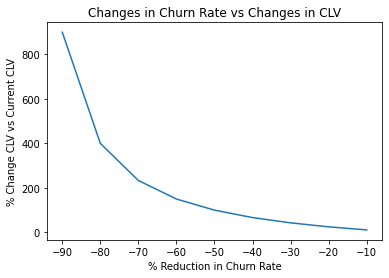

In [56]:
sns.lineplot(x = '% Reduction in Churn Rate',
             y='% Change CLV vs Current CLV',
             data=churn_graph2).set(title="Changes in Churn Rate vs Changes in CLV")


## Next Steps

### What are some of the quick wins that can be leveraged?

- Leverage surveys to obtain feedback, check customer satisfaction from time to time (and mitigate risk before customer churn happens if customer is dissatisfied)
- If data is not available for logging customer service interactions, invest in the infrastructure to log customer service interactions.  If data is available, dive into the data to identify opportunities for improvement for customer service training
- Market research on the competition to assess what kinds of products the competition might be offering that we aren't, and evaluating what types of products customers are wanting.

### Future projects

- Building a comprehensive system that identifies churn risk (based on the model we have built now), attempts to mitigate churn risk based on the factors we found that lowers churn risk, (through surveys, recommending certain services, offering cheaper plans, etc.) and empower our sales teams with data to act before customer churn happens.